In [1]:
!pip install --upgrade caer canaro

     |████████████████████████████████| 838 kB 866 kB/s eta 0:00:01
     |████████████████████████████████| 21.6 MB 12.0 MB/s eta 0:00:01
     |████████████████████████████████| 57.4 MB 42.8 MB/s eta 0:00:01


In [2]:
import os
import caer
import canaro
import numpy as np
import cv2 as cv
import gc   #For garbage collection
import sklearn.model_selection as skm 

In [3]:
#deep computer vision model expects all of the image data to be of the same size
IMG_SIZE = (80,80) #all the images in the dataset will have to be resized to the same size before being fed into the model
channels = 1  #we do not require color in the image, so 1, which means gray-scale
char_path = r'../input/the-simpsons-characters-dataset/simpsons_dataset'

In [4]:
#now we want the top 10 characters which have the most number of images in the dataset
# Creating a character dictionary, sorting it in descending order
char_dict = {}
for char in os.listdir(char_path):  #going through every folder inside simpsons_dataset
    char_dict[char] = len(os.listdir(os.path.join(char_path,char)))  #getting number of images stored in each folder and adding it to the dictionary

# Sort in descending order of the number of images
char_dict = caer.sort_dict(char_dict, descending=True)
char_dict

[('homer_simpson', 2246),
 ('ned_flanders', 1454),
 ('moe_szyslak', 1452),
 ('lisa_simpson', 1354),
 ('bart_simpson', 1342),
 ('marge_simpson', 1291),
 ('krusty_the_clown', 1206),
 ('principal_skinner', 1194),
 ('charles_montgomery_burns', 1193),
 ('milhouse_van_houten', 1079),
 ('chief_wiggum', 986),
 ('abraham_grampa_simpson', 913),
 ('sideshow_bob', 877),
 ('apu_nahasapeemapetilon', 623),
 ('kent_brockman', 498),
 ('comic_book_guy', 469),
 ('edna_krabappel', 457),
 ('nelson_muntz', 358),
 ('lenny_leonard', 310),
 ('mayor_quimby', 246),
 ('waylon_smithers', 181),
 ('maggie_simpson', 128),
 ('groundskeeper_willie', 121),
 ('barney_gumble', 106),
 ('selma_bouvier', 103),
 ('carl_carlson', 98),
 ('ralph_wiggum', 89),
 ('patty_bouvier', 72),
 ('martin_prince', 71),
 ('professor_john_frink', 65),
 ('snake_jailbird', 55),
 ('cletus_spuckler', 47),
 ('rainier_wolfcastle', 45),
 ('simpsons_dataset', 42),
 ('agnes_skinner', 42),
 ('sideshow_mel', 40),
 ('otto_mann', 32),
 ('fat_tony', 27),
 (

In [5]:
#Grabbing the names of the first 10 elements from the sorted dictionary and storing it in a list:
characters = []
count = 0
for i in char_dict:
    characters.append(i[0])  #appending the NAME of the character in the list 
    count += 1
    if count >= 10:   #we only want the top 10 characters that have the most number of images, so when count reaches 10,break.
        break
characters

['homer_simpson',
 'ned_flanders',
 'moe_szyslak',
 'lisa_simpson',
 'bart_simpson',
 'marge_simpson',
 'krusty_the_clown',
 'principal_skinner',
 'charles_montgomery_burns',
 'milhouse_van_houten']

In [6]:
# Create the training data
train = caer.preprocess_from_dir(char_path, characters, channels=channels, IMG_SIZE=IMG_SIZE, isShuffle=True,verbose=0)
#this will go through every folder inside char_path and will look at every element inside 'characters'.For every character inside characters it will go through the folder of that particular character and add all the images of that particular character to the trainset

[INFO] Could not find a file to load from. Generating the training data
----------------------------------------------
----------------------------------------------
[INFO] 13811 files preprocessed! Took 2m 6s


/opt/conda/lib/python3.7/site-packages/caer/core.py:72: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(obj, dtype=dtype, order=order)


In [7]:
# Number of training samples
len(train)   #13811 images inside training set
#currently the training set is a list with 13811 lists inside it. Inside each of the sub-list are 2 elements: actual array(img) and the labels

13811

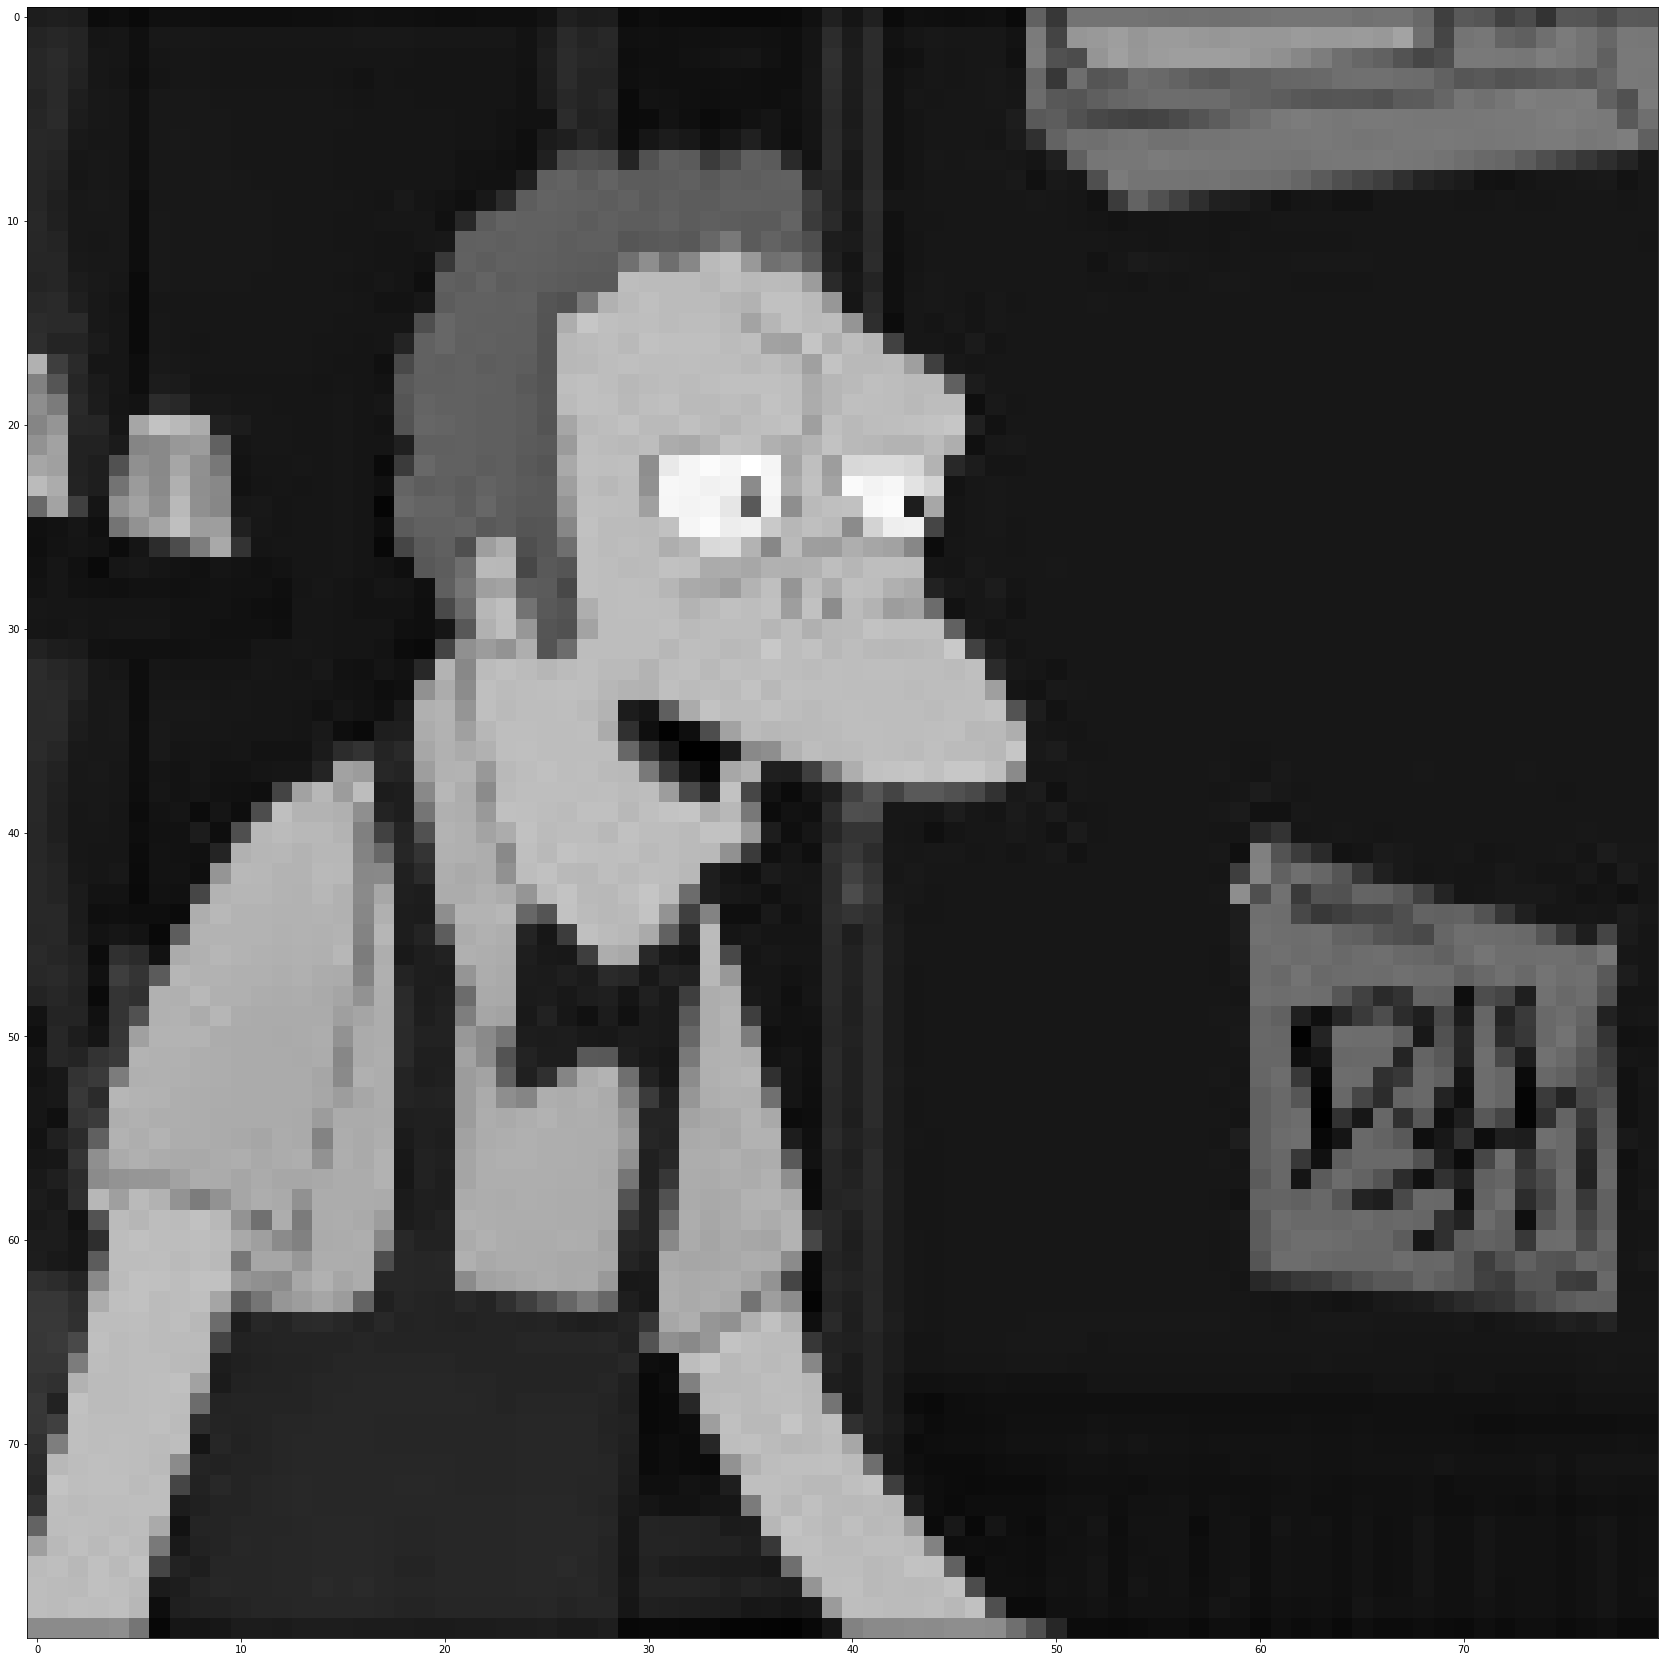

In [8]:
# Visualizing the data 
import matplotlib.pyplot as plt
plt.figure(figsize=(30,30))
plt.imshow(train[0][0], cmap='gray')
plt.show()

In [9]:
# Separating training set into features and labels
featureSet, labels = caer.sep_train(train, IMG_SIZE=IMG_SIZE)
#here the labels are the indexes of our characters list. So homer_simpson will have label 0 since his index is 0 in the 'characters' list

In [10]:
from tensorflow.keras.utils import to_categorical

# Normalize the featureSet ==> (0,1)
featureSet = caer.normalize(featureSet)
# Converting numerical labels to binary class vectors (one hot encoding)
labels = to_categorical(labels, len(characters))

In [11]:
#creating training and validation data 
#from sklearn.model_selection import train_test_split
#x_train,x_val,y_train,y_val=train_test_split(featureSet,labels,test_size=0.2)
split_data = skm.train_test_split(featureSet, labels, test_size=.2)
x_train, x_val, y_train, y_val = (np.array(item) for item in split_data)

In [12]:
#removing some of the variables not of use anymore to save memory
del train
del featureSet
del labels 
gc.collect()

3385

In [13]:
# Useful variables when training
BATCH_SIZE = 32
EPOCHS = 10

In [14]:
# Image data generator (introduces randomness in network ==> better accuracy)
#Will synthesize new images from already existing images
datagen = canaro.generators.imageDataGenerator()
train_gen = datagen.flow(x_train, y_train, batch_size=BATCH_SIZE)

In [15]:
# Create our model (returns a compiled model)
model = canaro.models.createSimpsonsModel(IMG_SIZE=IMG_SIZE, channels=channels, output_dim=len(characters), 
                                         loss='binary_crossentropy', decay=1e-7, learning_rate=0.001, momentum=0.9,
                                         nesterov=True)

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 80, 80, 32)        320       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 78, 78, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 39, 39, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 39, 39, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 39, 39, 64)        18496     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 37, 37, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 18, 18, 64)       

In [17]:
# Training the model

from tensorflow.keras.callbacks import LearningRateScheduler  #schedules learning rate at specific intervals to make model train better
callbacks_list = [LearningRateScheduler(canaro.lr_schedule)]
training = model.fit(train_gen,
                    steps_per_epoch=len(x_train)//BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(x_val,y_val),
                    validation_steps=len(y_val)//BATCH_SIZE,
                    callbacks = callbacks_list)

Epoch 1/10
345/345 [==============================] - 45s 116ms/step - loss: 0.3908 - accuracy: 0.1437 - val_loss: 0.3394 - val_accuracy: 0.1567
Epoch 2/10
345/345 [==============================] - 31s 91ms/step - loss: 0.3290 - accuracy: 0.1641
Epoch 3/10
345/345 [==============================] - 32s 91ms/step - loss: 0.3234 - accuracy: 0.1609
Epoch 4/10
345/345 [==============================] - 32s 92ms/step - loss: 0.3229 - accuracy: 0.1607
Epoch 5/10
345/345 [==============================] - 32s 91ms/step - loss: 0.3190 - accuracy: 0.1773
Epoch 6/10
345/345 [==============================] - 31s 91ms/step - loss: 0.3084 - accuracy: 0.2160
Epoch 7/10
345/345 [==============================] - 32s 91ms/step - loss: 0.3050 - accuracy: 0.2394
Epoch 8/10
345/345 [==============================] - 32s 91ms/step - loss: 0.3016 - accuracy: 0.2564
Epoch 9/10
345/345 [==============================] - 31s 91ms/step - loss: 0.3003 - accuracy: 0.2754
Epoch 10/10
345/345 [==================

Testing

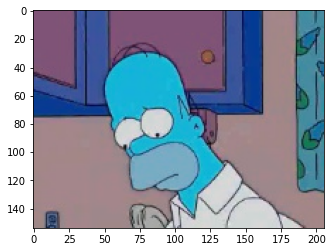

In [26]:
test_path = r'../input/the-simpsons-characters-dataset/kaggle_simpson_testset/kaggle_simpson_testset/homer_simpson_20.jpg'

img = cv.imread(test_path)

plt.imshow(img)
plt.show()

In [27]:
def prepare(image):
    image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    image = cv.resize(image, IMG_SIZE)
    image = caer.reshape(image, IMG_SIZE, 1)
    return image

In [28]:
predictions = model.predict(prepare(img))

In [29]:
# Getting class with the highest probability
print(characters[np.argmax(predictions[0])])

homer_simpson
